<a href="https://colab.research.google.com/github/22116001/Neural-Style-Transfer/blob/main/Neural_Style_TRansfer5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Mounting drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

image_directory = "/content/drive/MyDrive/Testing images/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Determining the availability of GPU and cuda.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128

Loading and resizing images

In [15]:
def load_image(image_path, size):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

def dynamic_load_images(content_path, style_path, size):
    content_img = load_image(content_path, size)
    style_img = load_image(style_path, [content_img.size(2), content_img.size(3)])
    assert style_img.size() == content_img.size(), "Style and content images must be of the same size"
    return content_img, style_img

Displaying image

In [16]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

Content loss

In [17]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Gram Matrix

In [18]:
def gram_matrix(input):
    batch_size, num_channels, height, width = input.size()
    features = input.view(batch_size * num_channels, height * width)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_channels * height * width)

Style loss

In [19]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Loading pre-trained VGG-19 model.

In [20]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Mean and std for normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Normalising

In [21]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Extracting style and content layer

In [22]:
def get_model_and_losses(cnn, normalization_mean, normalization_std,
                         style_img, content_img,
                         content_layers=['conv_4'],
                         style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Dynamic loading of content and style images

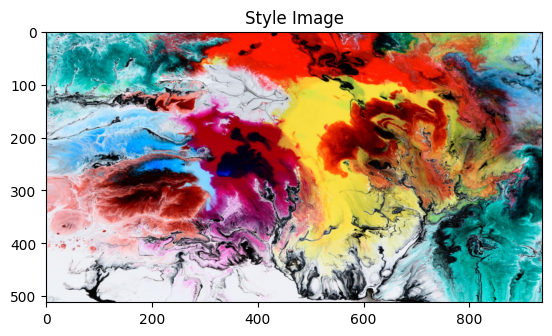

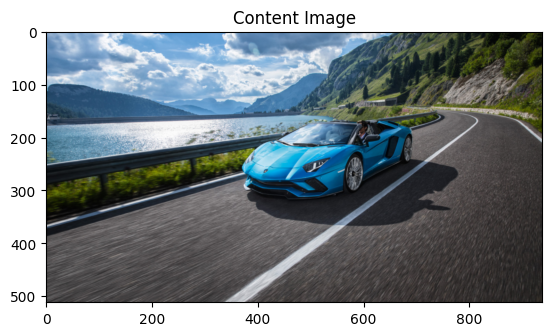

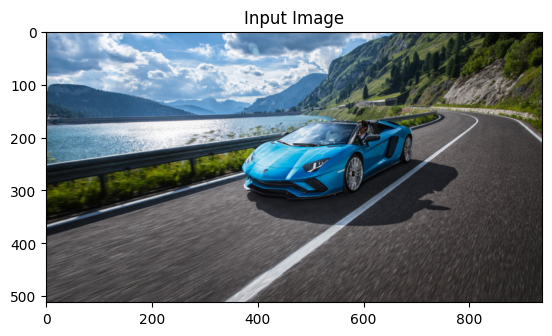

In [23]:
content_path = image_directory + "content1.jpg"  # Change as needed
style_path = image_directory + "style1.jpg"  # Change as needed
content_img, style_img = dynamic_load_images(content_path, style_path, imsize)

input_img = content_img.clone()

plt.figure()
show_image(style_img, title='Style Image')

plt.figure()
show_image(content_img, title='Content Image')

plt.figure()
show_image(input_img, title='Input Image')

Optimizer function

In [24]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Style Transfer function

In [25]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [-200]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


Running style transfer function

Building the style transfer model...


<ipython-input-21-f9c14a6a0341>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-21-f9c14a6a0341>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing...
run -150:
Style Loss : 273.53369140625 Content Loss: 20.655845642089844
run -100:
Style Loss : 84.12511444091797 Content Loss: 22.21933364868164
run -50:
Style Loss : 46.02553939819336 Content Loss: 21.420137405395508
run 0:
Style Loss : 30.550392150878906 Content Loss: 20.223743438720703
run 50:
Style Loss : 19.53977394104004 Content Loss: 19.606901168823242
run 100:
Style Loss : 12.317668914794922 Content Loss: 19.02245330810547
run 150:
Style Loss : 7.8713765144348145 Content Loss: 18.24905014038086
run 200:
Style Loss : 5.5518083572387695 Content Loss: 17.505266189575195
run 250:
Style Loss : 4.041164398193359 Content Loss: 16.80878257751465
run 300:
Style Loss : 2.9992334842681885 Content Loss: 16.381938934326172


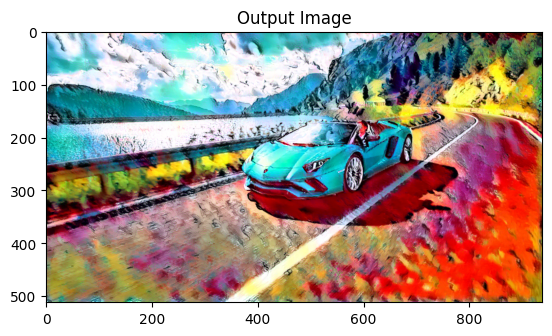

In [26]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=300)

plt.figure()
show_image(output, title='Output Image')

plt.ioff()
plt.show()